# Подготовка данных для модели оценки заголовка

Введенные или сгенерированные заголовки нужно как-то оценивать. Так как главной целью обычно является увеличение количества просмотров, то в качестве критерия нужно использовать число просмотров у ранее опубликованных статей. То есть перед нами стоит задача **регрессии**: на входе заголовок, на выходе число (балл от 0.0 до 10.0 с точностью 0.1).

In [182]:
import warnings
warnings.filterwarnings('ignore')

# standard libraries
import gc
import pickle

# data processing libraries
import numpy as np
import pandas as pd

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

# make numpy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

# data processing progress bar
from tqdm.auto import tqdm
tqdm.pandas()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# пути к датасетам
DATASETS_PATH = "/home/leo/DATASETS"

# общий для приложений словарь с источником данных и их характеристиками
with open('../sources.pickle', 'rb') as f:
    sources = pickle.load(f)

%matplotlib inline

# Подготовка данных
## 1. Соединение датафреймов

В нашем распоряжении имеется множество данных, полученных в результате парсинга. Объединим их в один большой датасет для построения модели оценки заголовков. Для построения будем использовать те датасеты (сайты), которые содержат информацию о количестве просмотров статей.

In [192]:
# соединяем датасеты в один общий датасет с именем df
dfs = dict()

for source in sources:
    dfs[source] = pd.read_csv(f"{DATASETS_PATH}/{source}.csv",
                              index_col=0,
                              parse_dates=['post_time', 'parse_time'])
    dfs[source]['source'] = source
    
df = pd.concat(dfs[key] for key in dfs)

# преобразуем количество просмотров
df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# удаляем закрытые и недоступные статьи
df = df.drop(df[df.views_num == 0.0].index)

# удаляем дубликаты
# df = df.drop_duplicates()
df = df.loc[~df.index.duplicated(keep='last')]
df.views_num = df.views_num.astype('Int32')
df.likes_num = df.likes_num.astype('Int16')
df.favs_num = df.favs_num.astype('Int16')
df.comments_num = df.comments_num.astype('Int16')

# convinient order of columns
df = df[['title', 'short_text', 'views_num',
         'post_time', 'parse_time',
         'likes_num', 'favs_num', 'comments_num',
         'source', 'filename']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228637 entries, https://tproger.ru/articles/kak-bystro-razvernut-hranilishhe-i-analitiku-dannyh-dlja-biznesa/ to https://habr.com/ru/company/croc/blog/548018/
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         228636 non-null  object        
 1   short_text    2602 non-null    object        
 2   views_num     228637 non-null  Int32         
 3   post_time     228637 non-null  object        
 4   parse_time    228637 non-null  datetime64[ns]
 5   likes_num     226018 non-null  Int16         
 6   favs_num      226018 non-null  Int16         
 7   comments_num  226018 non-null  Int16         
 8   source        228637 non-null  object        
 9   filename      228637 non-null  object        
dtypes: Int16(3), Int32(1), datetime64[ns](1), object(5)
memory usage: 15.3+ MB


In [215]:
filename = 'it_articles_ru'
df = df.reset_index()
df.to_feather(f'{DATASETS_PATH}/{filename}.feather', compression='zstd')

In [202]:
df.to_feather(f'{filename}.feather')

In [214]:
%%time
pd.read_feather(f'{filename}.feather').set_index('index')

CPU times: user 369 ms, sys: 77.5 ms, total: 447 ms
Wall time: 389 ms


,title,short_text,views_num,post_time,parse_time,likes_num,favs_num,comments_num,source,filename
index,,,,,,,,,,
https://tproger.ru/articles/kak-bystro-razvernut-hranilishhe-i-analitiku-dannyh-dlja-biznesa/,Как быстро развернуть хранилище и аналитику да...,Сегодня хочу рассказать историю проекта по зап...,7825,2021-03-01 12:32:23+03:00,2021-03-14 00:00:00.000000,<NA>,<NA>,<NA>,tproger,59a7ab25-11f7-502a-b63a-bbdcb121f488
https://tproger.ru/articles/7-prakticheskih-zadanij-s-sobesedovanija-na-poziciju-junior-java-developer/,7 практических заданий с собеседования на пози...,Для начинающего разработчика очень важно не то...,6741,2021-03-01 09:05:11+03:00,2021-03-14 00:00:00.000000,<NA>,<NA>,<NA>,tproger,80f10716-5243-55ca-a67d-4dfe77cd27a5
https://tproger.ru/quiz/test-chto-mozhet-jeta-nejroset/,"Тест: что реально, а что создала нейросеть?",Сегодня нейронные сети используются в сельском...,4032,2021-02-26 19:39:50+03:00,2021-03-14 00:00:00.000000,<NA>,<NA>,<NA>,tproger,aaffd2c5-592f-5d7b-b972-95073d0da49a
https://tproger.ru/articles/kak-najti-dejstvitelno-horoshij-kurs-po-razrabotke-8-shagov-na-puti-k-pravilnomu-vyboru/,Как найти действительно хороший курс по разраб...,Сразу хочется пошутить и предложить разработат...,1121,2021-02-26 17:29:00+03:00,2021-03-14 00:00:00.000000,<NA>,<NA>,<NA>,tproger,16f80dbb-8e7c-5a5b-9025-b2fdef30bfd0
https://tproger.ru/articles/blackbox-skanery-v-processe-ocenki-bezopasnosti-prilozhenija/,Blackbox-сканеры в процессе оценки безопасност...,Профиль задач quality engineer (QE) достаточно...,187,2021-02-26 15:16:46+03:00,2021-03-14 00:00:00.000000,<NA>,<NA>,<NA>,tproger,9d58bde6-7aaf-57a4-b381-25171b9a368f
...,...,...,...,...,...,...,...,...,...,...
https://habr.com/ru/post/550640/,FOSS News №64 – дайджест материалов о свободно...,None,1700,2021-04-04 21:27:00+03:00,2021-04-15 11:31:43.788688,4,5,0,habr,07673689-7a82-5c34-a3a8-43c266febcc4
https://habr.com/ru/company/skyeng/blog/546314/,"Как дойти до CQRS, если у тебя PHP",None,4400,2021-03-17 10:02:00+03:00,2021-04-15 11:31:44.742286,23,48,1,habr,e4332d8b-43ae-5a46-9151-c1c32d2b81d8
https://habr.com/ru/company/typeable/blog/548574/,Зачем мы транспилируем Haskell в JavaScript,None,3400,2021-03-23 17:19:00+03:00,2021-04-15 11:31:45.370494,14,24,13,habr,5718bb2e-3a8b-556c-8556-8510504fd89d


Когда есть полные дубликаты заголовков, оставлять тот, что имеет больше просмотров.

In [ ]:
# Добавить дату парсинга к остальным датасетам, для небольших можно адаптировать и извлечение текста

# Временные ячейки для работы со статьями Хакера

In [118]:
import datetime
import dask.dataframe as dd
import re

df = dd.read_csv(f'{DATASETS_PATH}/xakep*.csv', dtype={'views_num': 'object'}).compute()
df = df.set_index('title-href')
df = df.drop(columns='web-scraper-order')
#df['pag_start'] = df['web-scraper-start-url'].apply(lambda x: int(x.split('/')[-2]))
df = df.drop(columns='web-scraper-start-url')

# преобразуем количество просмотров
df.views_num = df.views_num.apply(lambda x: int(''.join(filter(str.isdigit, str(x)))))

# удаляем закрытые и недоступные статьи
df = df.drop(df[df.views_num == 0.0].index)

# удаляем дубликаты
df = df.loc[~df.index.duplicated(keep='last')]

def find_digit(s):
    digit_string = re.findall(r'\d+', s)
    if digit_string:
        return int(digit_string[0])
    else:
        return 0

df.comments_num = df.comments_num.apply(find_digit)

df['parse_time'] = datetime.datetime.now().date()
df['comments_num'] = df['comments_num'].astype('int8')
df['post_date'] = pd.to_datetime(df['post_date'], dayfirst=True, errors='coerce')
df = df.rename({'title-href':'url', 'post_date':'post_time'}, axis=1)
df.head()
df.to_csv(f'{DATASETS_PATH}/xakep.csv')
#df.sort_values(by='comments_num', ascending=False)

## 2. Коррекция случаев заниженного числа просмотров
Число просмотров на сайтах иногда существуенно отстает от предполагаемого или не всегда корректно рассчитано. Особенно это заметно на когда количество просмотров меньше числа лайков и добавлений в избранные статьи. Чтобы скорректировать такие значения, построим простую  регрессионную SGD-модель на данных, внушающих доверие и экстраполируем результат на «подозрительные» данные о числе просмотров.

In [3]:
df['post_time'] = pd.to_datetime(df['post_time'], utc=True)
df['mln_secs_to_now'] = (pd.Timestamp.now(tz='UTC') - df['post_time']).apply(lambda x: x.total_seconds())*1e-6
df_tmp = df[['likes_num', 'favs_num', 'comments_num', 'views_num']].dropna()
df_tmp['suspicious'] = [False]*df_tmp.shape[0]
for col in ('likes', 'favs', 'comments'):
    df_tmp['suspicious'] += df_tmp[f'{col}_num'] > 0.1*df_tmp['views_num']

df_tmp_susp = df_tmp[df_tmp['suspicious'] == True]
df_tmp = df_tmp[df_tmp['suspicious'] == False]
df_tmp = df_tmp.drop(columns=['suspicious'])
df_tmp_susp = df_tmp_susp.drop(columns=['suspicious'])

y = df_tmp['views_num']
X = df_tmp.drop(columns=['views_num'])
reg = make_pipeline(StandardScaler(),
                    RandomForestRegressor(n_jobs=20))
reg.fit(X, y)
df_tmp_susp['views_num'] = reg.predict(df_tmp_susp.drop(columns=['views_num']))
df_tmp_susp['views_num'] = df_tmp_susp['views_num'].apply(round)
df_tmp = pd.concat([df_tmp, df_tmp_susp])
df.update(df_tmp)

## 3. Преобразование целевой переменной: от числа просмотров к рейтингу
Оставим только данные, которые используются для построения модели: текст заголовка (`X`) и число просмотров (`y`). Отсортируем статьи по количеству просмотров и зададим для каждой позиции рейтинг `score`, равномерно распределенных между 0 для непросматриваемой статьи и 100 для самой просматриваемой. Таким образом, оценка в 90 означает, что подобные заголовки имели не меньшее число просмотров, чем 90% иследованного набора данных. Впоследствии эти баллы будут использоваться для отображения шкалы 0-100 в 0.0-10.0.

In [109]:
Xy = df[['title', 'views_num']]
Xy['title'] = Xy['title'].apply(str)
#max_title_length = Xy.title.apply(len).max()
Xy.sort_values(by='views_num', inplace=True)

bound = round(Xy.shape[0]*0.2)
Xy['score'] = 0
Xy.score.iloc[-bound:] = 1
Xy['score'] = Xy['score'].astype('int8')
Xy.drop(columns='views_num', inplace=True)

In [110]:
Xy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229192 entries, https://habr.com/ru/post/81826 to https://habr.com/ru/post/491974
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   229192 non-null  object
 1   score   229192 non-null  int8  
dtypes: int8(1), object(1)
memory usage: 3.7+ MB


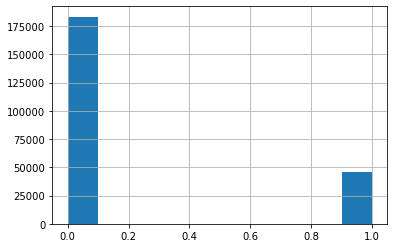

In [111]:
Xy.score.hist()

In [112]:
Xy.to_pickle('Xy.pickle', compression='gzip', protocol=4)

# XXX Archive & Drafts XXX

In [ ]:
# парсинг сайтов с помощью расширения web scrapy

# import datetime

# df_tmp = pd.read_csv(f'{DATASETS_PATH}/xakep.csv')
# df_tmp = df_tmp.drop(columns=['web-scraper-order', 'web-scraper-start-url'])
# df_tmp = df_tmp.set_index('title-href')
# #df_tmp = df_tmp.fillna(0)

# def find_digit(s):
#     digit_string = re.findall(r'\d+', s)
#     if digit_string:
#         return int(digit_string[0])
#     else:
#         return 0

# df_tmp.comments_num = df_tmp.comments_num.apply(find_digit)
# df_tmp['parse_time'] = datetime.datetime.now()
# df_tmp['comments_num'] = df_tmp['comments_num'].replace('Обсудить', '0')
# df_tmp['comments_num'] = df_tmp['comments_num'].astype('int8')
# df_tmp['likes_num'] = df_tmp['likes_num'].astype('int8')
# df_tmp['favs_num'] = df_tmp['favs_num'].astype('int8')
# df_tmp.set_index('url-href').to_csv(f'{DATASETS_PATH}/thecode.csv')

In [ ]:
# генерация дополнительных признаков
# Xy.loc[:, ['title']] = Xy.title.apply(str)

# Xy.loc[:, ['doc']] = Xy.title.progress_apply(nlp)

# длина заголовка в символах
# Xy.loc[:, ['len']] = Xy.title.apply(len)

# количество токенов
# Xy.loc[:, ['tokens_num']] = Xy.tokens.apply(lambda x: len(x))

# Токенизация большого числа заголовков — затратная по времени операция.
# Поэтому предварительно токенизированные заголовки хранятся в виде
# сжатого датафрайма
#tokenized_titles = pd.read_pickle(TOKENIZED_TITLES_PATH, compression='gzip')

# for i in [3, 8, 9]:
#     spacy.displacy.render(tokenized_titles.iloc[i], style='ent', jupyter=True)

# tokenized_titles.to_pickle(path=TOKENIZED_TITLES_PATH, compression='gzip')